
# IMDB Movie Reviews Sentiment Analysis with NLP and Machine Learning

This project performs sentiment analysis on IMDB movie reviews using Natural Language Processing (NLP) and Machine Learning models.

**Objectives:**
- Preprocess reviews (cleaning, stopwords removal, lemmatization).
- Visualize insights with word clouds and distributions.
- Train ML models (Logistic Regression, Random Forest, SVM) with TF-IDF features.
- Compare models with cross-validation and classification metrics.
- Optimize models with GridSearchCV.


## Setup

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Roukaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Roukaya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Roukaya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Load Dataset

In [2]:

# Replace with your dataset path after download from Kaggle
df = pd.read_csv("IMDB Dataset.csv")

print(df.shape)
df.head()


(10000, 3)


,Unnamed: 0,score,review
0,0,1,Stuning even for the non-gamer: This sound tr...
1,1,1,The best soundtrack ever to anything.: I'm re...
2,2,1,Amazing!: This soundtrack is my favorite musi...
3,3,1,Excellent Soundtrack: I truly like this sound...
4,4,1,"Remember, Pull Your Jaw Off The Floor After H..."


## Exploratory Data Analysis

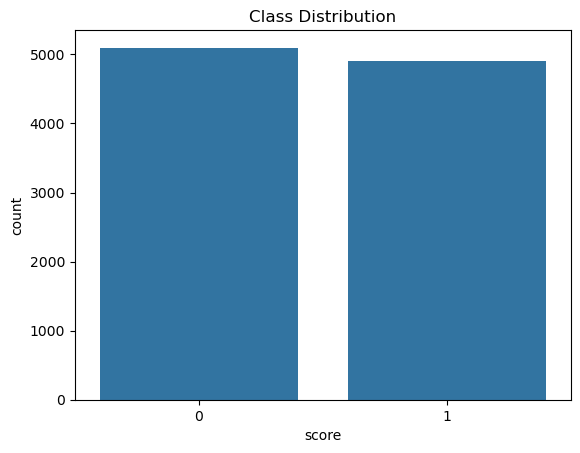

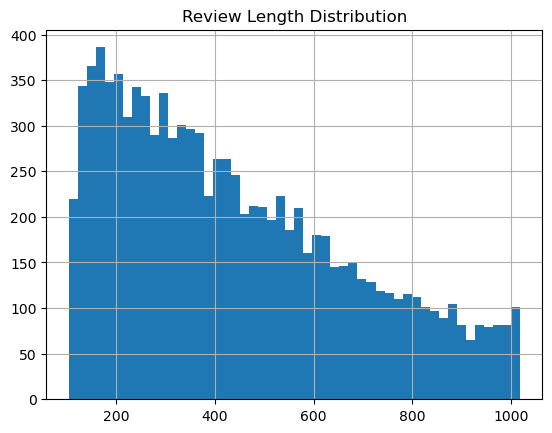

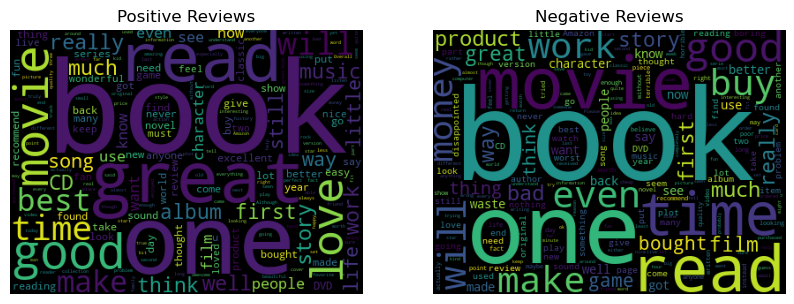

In [5]:

# Class distribution
sns.countplot(x=df['score'])
plt.title("Class Distribution")
plt.show()

# Review length distribution
df['length'] = df['review'].apply(len)
df['length'].hist(bins=50)
plt.title("Review Length Distribution")
plt.show()

# Word cloud for positive and negative reviews
pos_text = " ".join(df[df['score']==1]['review'])
neg_text = " ".join(df[df['score']==0]['review'])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=300).generate(pos_text))
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=300).generate(neg_text))
plt.axis("off")
plt.title("Negative Reviews")

plt.show()


## Text Preprocessing

In [6]:

import re

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove urls
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()


,review,clean_review
0,Stuning even for the non-gamer: This sound tr...,stuning even nongamer sound track beautiful pa...
1,The best soundtrack ever to anything.: I'm re...,best soundtrack ever anything im reading lot r...
2,Amazing!: This soundtrack is my favorite musi...,amazing soundtrack favorite music time hand in...
3,Excellent Soundtrack: I truly like this sound...,excellent soundtrack truly like soundtrack enj...
4,"Remember, Pull Your Jaw Off The Floor After H...",remember pull jaw floor hearing youve played g...


## Train-Test Split

In [7]:

X = df['clean_review']
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Modeling with Pipelines

In [8]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Linear SVM": LinearSVC()
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', model)
    ])
    scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=['accuracy','f1'], return_train_score=False)
    results[name] = scores

pd.DataFrame({m:{"accuracy":np.mean(r['test_accuracy']),"f1":np.mean(r['test_f1'])} for m,r in results.items()})


,Logistic Regression,Random Forest,Linear SVM
accuracy,0.855500,0.828000,0.845500
f1,0.853059,0.823108,0.843599


## Hyperparameter Tuning (Logistic Regression Example)

In [9]:

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'clf__C': [0.1, 1, 10]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)


Best Params: {'clf__C': 1}


## Evaluation on Test Set

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1019
           1       0.85      0.84      0.85       981

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



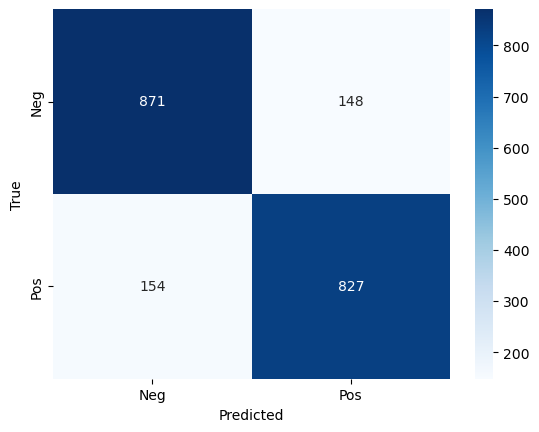

In [10]:

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Save Best Model

In [11]:

joblib.dump(grid.best_estimator_, "imdb_sentiment_model.pkl")


['imdb_sentiment_model.pkl']


## Conclusion

- Preprocessed and cleaned IMDB reviews using stopwords removal and lemmatization.  
- Visualized class distribution, review lengths, and word clouds.  
- Trained Logistic Regression, Random Forest, and Linear SVM with TF-IDF features.  
- Tuned Logistic Regression with GridSearchCV for best hyperparameters.  
- Evaluated models with classification report and confusion matrix.  
- Saved the best model for future inference.  

This notebook is a complete workflow for movie review sentiment analysis.
